<a href="https://colab.research.google.com/github/NastasiaMazur/StoryTeller/blob/main/StoryTeller_3_books.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story Teller - ML

In [ ]:
#read-PDF imports here
!pip install PyPDF2
from PyPDF2 import PdfReader

#pre-processing imports here
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#file locations on drive
grimm_url = '/content/drive/MyDrive/Story_Teller/FairytalesByTheBrothersGrimm.txt'
coraline_url = '/content/drive/MyDrive/Story_Teller/Coraline.pdf'
alice_url = '/content/drive/MyDrive/Story_Teller/AlicesAdvanturesInWonderland.txt'

In [ ]:
#load punctuation symbols
punct = string.punctuation

# **Pre-processing Coraline**

In [ ]:
#a function to pre process Coraline by Neil Gaiman
import PyPDF2
def preprocess_coraline(book):
  '''
  param book: url od a PDF book file
  '''
  output = ""                                     # to store the text extracted from the PDF
  data = open(book, 'rb')
  data = PyPDF2.PdfReader(data)                   # opens the PDF file in binary mode and reads it using PyPDF2 library
  npages = len(data.pages)                        # determines the number of pages in the PDF
  for i in range(npages):                         # iterates through each page of the PDF, extracts the text from each page, and appends it to the output string
    page_i = data.pages[i].extract_text()
    output += page_i
  output = output[1227:]                          # removes the first 1227 characters from output string: title, author, table of contents, introductory quote
  output = output.lower()
  for word in output:
    for char in word:
        if char in punct:
            word = word.replace(char, "")
  remove_punct = "".join([word for word in output if word not in punct])
  processed = word_tokenize(remove_punct)
  print('Coraline database includes {} tokens, and {} unique tokens after editing'.format(len(processed), len(set(processed))))
  return processed

coraline = preprocess_coraline(coraline_url)

Coraline database includes 33352 tokens, and 3660 unique tokens after editing


## **Preprocessing Alice in Wonderland**

In [ ]:
#a function to pre process Alice's Advantures in Wonderland by Lewis Carroll

def load_alice(text_file, punct, not_a_word):
    '''
    param text_file: url to Project Gutenberg's text file for Alice's Advantures in Wonderland by Lewis Carroll
    param punct: a string of punctuation characters we'd like to filter
    param not_a_word: a list of words we'd like to filter
    '''
    book = open(text_file, 'r')
    book = book.read()
    book = book[715:145060]
    book_edit = re.sub('[+]', '', book)
    book_edit = re.sub(r'(CHAPTER \w+.\s)', '', book)
    words = word_tokenize(book_edit.lower())

    word_list = []

    # filtering punctuation and non-words
    for word in words:
        for char in word:
            if char in punct:
                word = word.replace(char, "")
        if word not in punct and word not in not_a_word:
            word_list.append(word)

    print('Alice database includes {} tokens, and {} unique tokens after editing'.format(len(word_list), len(set(word_list))))
    return word_list

alice = load_alice(alice_url, (punct.replace('-', "") + '’' + '‘'), ['s', '--', 'nt', 've', 'll', 'd'])

Alice database includes 26612 tokens, and 2596 unique tokens after editing


# **Preprocessing Grimm**


In [ ]:
def load_fairytales(text_file):
    '''
    param text_file: url to Project Gutenberg's text file for Fairytales by The Brothers Grimm
    '''
    book = open(text_file, encoding='cp1252')
    book = book.read()
    book = book[2376:519859]
    book_edit = re.sub('[(+*)]', '', book)
    words = word_tokenize(book_edit.lower())

    # filtering punctuation inside tokens (example: didn't or wow!)
    for word in words:
        for char in word:
            if char in punct:
                word = word.replace(char, "")

    # filtering punctuation as alone standing tokens(example: \ or ,)
    words = [word for word in words if word not in punct]

    print('Fairytales database includes {} tokens, and {} unique tokens after editing'.format(len(words), len(set(words))))
    return words

brothers_grimm = load_fairytales(grimm_url)

Fairytales database includes 106324 tokens, and 5335 unique tokens after editing


# **Combined database including all books**

In [ ]:
data = coraline + alice + brothers_grimm
data[:10]

['beaten',
 '—g',
 'k',
 'chesterton',
 '1',
 'coraline',
 'discovered',
 'the',
 'door',
 'a']

# **Convert Data into Numeric Values**

In [ ]:
vocab = set(data)
vocab_size = len(data)

word_to_index = {word: i for i, word in enumerate(vocab)}
data = [word_to_index[word] for word in data]    # list comprehension

data [:10]

[7625, 7901, 5861, 5991, 511, 3471, 5142, 6695, 4068, 7764]

In [ ]:
word_to_index['beaten']

7625

# **Batching Data**

In [ ]:
batch_size = 5 # look into first 5 words in each batch

train_data = [([data[i], data[i+1],data[i+2], data[i+3], data[i+4]], data[i+5]) for i in range(vocab_size - batch_size)] #features + target word

train_data[:10]

[([7625, 7901, 5861, 5991, 511], 3471),
 ([7901, 5861, 5991, 511, 3471], 5142),
 ([5861, 5991, 511, 3471, 5142], 6695),
 ([5991, 511, 3471, 5142, 6695], 4068),
 ([511, 3471, 5142, 6695, 4068], 7764),
 ([3471, 5142, 6695, 4068, 7764], 3343),
 ([5142, 6695, 4068, 7764, 3343], 6947),
 ([6695, 4068, 7764, 3343, 6947], 8067),
 ([4068, 7764, 3343, 6947, 8067], 6617),
 ([7764, 3343, 6947, 8067, 6617], 6975)]

# **Defining the Neural Network**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

embedding_dim = 5

class StoryTeller(nn.Module):
  def __init__ (self, vocab_size, embedding_dim, batch_size):
    super(StoryTeller, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.linear1 = nn.Linear(batch_size * embedding_dim, 128)
    self.linear2 = nn.Linear(128, 512)
    self.linear3 = nn.Linear(512, vocab_size)

  def forward(self, inputs):
    embeds = self.embeddings(inputs).view((1,-1))
    out = F.relu(self.linear1(embeds))
    out = F.relu(self.linear2(out))
    out = self.linear3(out)
    log_probs = F.log_softmax(out, dim=1)
    return log_probs




In [ ]:
model = StoryTeller(vocab_size, embedding_dim, batch_size)
model

StoryTeller(
  (embeddings): Embedding(166288, 5)
  (linear1): Linear(in_features=25, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=166288, bias=True)
)

# **Defining Training Function**

In [ ]:
average_loss = []
def train (model, train_data, epochs, word_to_index):
  if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Training on GPU...")
  else:
    device = torch.device("cpu")
    print("Training on CPU...")

  model.to(device)

  for i in range(epochs):
    model.train()
    steps = 0
    print_every = 100
    running_loss = 0
    for feature, target in train_data:
      feature_tensor = torch.tensor(feature, dtype=torch.long).unsqueeze(0)  # Add a batch dimension
      feature_tensor = feature_tensor.to(device)
      target_tensor = torch.tensor([target], dtype=torch.long)  # Reshape to remove batch dimension
      target_tensor = target_tensor.to(device)
      model.zero_grad()
      log_probs = model(feature_tensor)
      loss = criterion(log_probs, target_tensor)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      steps += 1
      """
      feature_tensor = torch.tensor([feature], dtype = torch.long)
      feature_tensor = feature_tensor.to(device)
      #target_tensor = torch.tensor([feature], dtype = torch.long)
      target_tensor = torch.tensor(target, dtype=torch.long)
      target_tensor = target_tensor.to(device)
      model.zero_grad() #set gradients to 0
      log_probs = model(feature_tensor) #pass feature tensor into the model
      loss = criterion(log_probs, target_tensor)
      loss.backword()
      optimizer.step()
      running_loss += loss.item()
      step +=1
"""
      if steps % print_every == 0:
        model.eval()
        average_loss.append(running_loss/print_every)
        print("Epochs: {} / {}".format(i+1, epochs),
              "Training Loss: {:.3f} ".format(running_loss / print_every))
        running_loss = 0
      model.train()
    return model

# **Train Model**

In [ ]:
model = StoryTeller(vocab_size, embedding_dim, batch_size)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 10
device = 0

start_time =time.time()
model = train(model, train_data, epochs, word_to_index)

print("training took {} minutes".format(round((start_time - time.time())/60), 2))

Training on GPU...
Epochs: 1 / 10 Training Loss: 11.977 
Epochs: 1 / 10 Training Loss: 11.845 
Epochs: 1 / 10 Training Loss: 11.703 
Epochs: 1 / 10 Training Loss: 11.530 
Epochs: 1 / 10 Training Loss: 11.040 
Epochs: 1 / 10 Training Loss: 10.545 
Epochs: 1 / 10 Training Loss: 9.927 
Epochs: 1 / 10 Training Loss: 9.604 
Epochs: 1 / 10 Training Loss: 9.263 
Epochs: 1 / 10 Training Loss: 9.206 
Epochs: 1 / 10 Training Loss: 8.900 
Epochs: 1 / 10 Training Loss: 9.488 
Epochs: 1 / 10 Training Loss: 8.173 
Epochs: 1 / 10 Training Loss: 8.531 
Epochs: 1 / 10 Training Loss: 7.902 
Epochs: 1 / 10 Training Loss: 8.796 
Epochs: 1 / 10 Training Loss: 8.381 
Epochs: 1 / 10 Training Loss: 8.204 
Epochs: 1 / 10 Training Loss: 7.915 
Epochs: 1 / 10 Training Loss: 7.951 
Epochs: 1 / 10 Training Loss: 8.519 
Epochs: 1 / 10 Training Loss: 8.268 
Epochs: 1 / 10 Training Loss: 8.306 
Epochs: 1 / 10 Training Loss: 7.807 
Epochs: 1 / 10 Training Loss: 7.909 
Epochs: 1 / 10 Training Loss: 8.002 
Epochs: 1 / 1

# **Save Checkpoint**

In [ ]:
checkpoint_url = '/content/drive/MyDrive/Story_Teller/checkpoint3.pth'


checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'word_to_index': word_to_index,
              'index_to_word': {i: word for i, word in enumerate(vocab)},
              'epochs': epochs,
              'average_loss': average_loss,
              'device': device,
              'optimizer_state': optimizer.state_dict(),
              'batch_size': batch_size}

torch.save(checkpoint, checkpoint_url)

# **Load Checkpoint**

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.optimizer_state = checkpoint['optimizer_state']
    model.load_state_dict(checkpoint['state_dict'])
    model.device = checkpoint['device']
    model.word_to_index = checkpoint['word_to_index']
    model.index_to_word = checkpoint['index_to_word']
    model.average_loss = checkpoint['average_loss']
    return model

checkpoint_url = '/content/drive/MyDrive/Story_Teller/checkpoint3.pth'
model = load_checkpoint(checkpoint_url)
index_to_word = model.index_to_word
model

StoryTeller(
  (embeddings): Embedding(166288, 5)
  (linear1): Linear(in_features=25, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=166288, bias=True)
)

<Axes: >

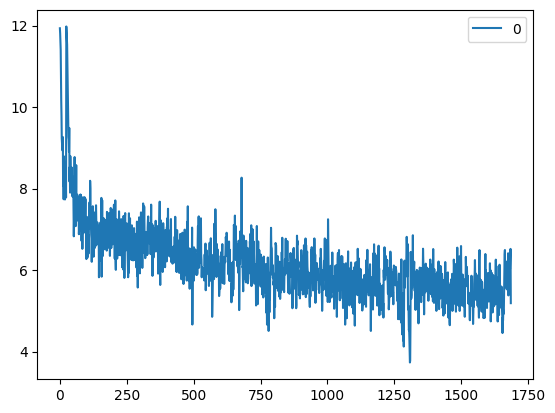

In [ ]:
import pandas as pd

loss_plot = pd.DataFrame(model.average_loss)
loss_plot.plot()

# **Predict Function**

In [ ]:
def predict(model, first_words ,story_len ,top_k):
    '''
    param model: trained model
    param first_words: a string of 5 (n_feature) words to begin the story
    param story_len: an integer symbolizing the number of words you'd like the story to have
    param top_k: the number of top probabilities per word that the network will randomly select from
    '''
    feature = (first_words.lower()).split(" ")
    for i in feature:
        story.append(i)
    for i in range(story_len):
        feature_idx = torch.tensor([word_to_index[word] for word in feature], dtype=torch.long)
        feature_idx = feature_idx.to(device)
        with torch.no_grad():
            output = model.double().forward(feature_idx)
        ps = torch.exp(output)
        topk_combined = ps.topk(top_k, sorted=True)
        #top kk probabilities
        topk_ps = topk_combined[0][0]
        #top kk classes
        topk_class = topk_combined[1][0]
        topk_class = [index_to_word[int(i)] for i in topk_class]
        next_word = random.choice(topk_class)
        feature = feature[1:]
        feature.append(next_word)
        story.append(next_word)
    return story

# **Predict**

In [ ]:
import random
first_words = input('Type the first {} words to start the story:\nexample: A lovely day at the\n'.format(batch_size))

top_k = 3
story_len = 50
story = []
device = 'cuda:0'

#Predicting and Handling User-Input Errors
try:
    prediction = predict(model, first_words, story_len, top_k)
except KeyError as error:
    print('Oops, looks like you\'ve selected a word that the network does not understand yet: ', error)
    if story[0] != "":
        story = story[len(first_words):]
    first_words = input('please select a different word:\nexample: A lovely day at the\n')
    prediction = predict(model, first_words, story_len, top_k)
except KeyError and RuntimeError:
    if story[0] != "":
        story = story[len(first_words):]
    first_words = input('Oops, looks like you\'ve typed {} words instead of {}!\n\nType the first 5 words to start the story:\nexample: A lovely day at the\n'.format(len(first_words.split(" ")), n_features))
    prediction = predict(model, first_words, story_len, top_k)

print('-----------------------------------------------------\n The STORY \n-----------------------------------------------------')
print(" ".join(story))

Type the first 5 words to start the story:
example: A lovely day at the
Another lovely day started as
-----------------------------------------------------
 The STORY 
-----------------------------------------------------
another lovely day started as they could the two man the bear had i will not to his bear ‘ i can and i was a bear and was his children ’ s and the bear and cried the forest was he had not and he took and he took his dwarf and they came


Next step:
 experiment with losses and optimizers and epochs, hidden dimentions and embedding dimentions